# Kaggle Playground Series - Season 3, Episode 19 - [4th Place Solution](https://www.kaggle.com/competitions/playground-series-s3e19/leaderboard)

**Goal:** Predict a full year of sales for various learning modules from different stores in different countries. Given years 2017 through 2021, predict sales for the year 2022. Models will be evaluated using symmetric mean absolute percentage error (SMAPE).

**Solution:**  My solution is a Poisson PyGAM model with 20 features. The model is cross-validated using 5-fold sliding window where the test set for each fold is separated into two parts (3 months and 9 months) to get a leaderboard estimate for public and private, respectively. The final 9 months of each test set is used for feature selection and selecting the number of splines.

The final features are:

- store and product (each label encoded)
- week day
- an indicator for an even year
- five sine and cosine features based on day of year and product
- indicators for December 26 through January 1
- indicators for May 7 through May 9 in Japan
- log of GDP per capita

My model achieves a median cross-validation score of 12.73% on the last 9 months of each year. This median score is skewed due to COVID-19 as demonstrated by my 2021 cross-validation score of 5.44% (and pre-2020 scores of ~5-6%). The final leadboard SMAPE score (based on the last 9 months of 2021) is 5.49%.

# 1. Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn; sn.set_style("white")

import warnings
warnings.filterwarnings("ignore")

import gc

import math
import random
import requests
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

!pip install pygam
from pygam import PoissonGAM, s, f, l

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 25.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.25.2 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.25.2 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.25.2 which is incompatible.
pymc3 3.11.5 requires scipy<1.8

In [2]:
def get_dataframe(address, train=False):
    """
    1. Read CSV.
    2. Convert date column to datetime.
    3. Drop 'id' column.
    """
    df = pd.read_csv(address)
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop('id', axis=1)
    if train:
        return df, df.pop("num_sold")
    return df

In [3]:
train_address = "/kaggle/input/playground-series-s3e19/train.csv"
train, target = get_dataframe(train_address, train=True)

test_address = "/kaggle/input/playground-series-s3e19/test.csv"
test = get_dataframe(test_address)

# 2. Create features

## Feature encoding country, store, and product

In [4]:
def create_encoded_features(df_train, df_test):
    """
    Create one hot encoded and ordinal encoded features for 'country', 'store', and 'product' features.
    """
    enc = OneHotEncoder(sparse_output=False)
    train_ohe = enc.fit_transform(df_train.loc[:, ['country', 'store', 'product']])
    encoded_feature_names = list(enc.categories_[0]) + list(enc.categories_[1]) + list(enc.categories_[2])
    df_train = pd.concat([df_train, pd.DataFrame(train_ohe, columns=encoded_feature_names).astype(int)],axis=1)
    test_ohe = enc.transform(df_test.loc[:, ['country', 'store', 'product']])
    df_test = pd.concat([df_test, pd.DataFrame(test_ohe, columns=encoded_feature_names).astype(int)],axis=1)
    
    enc = OrdinalEncoder()
    df_train[['country_enc', 'store_enc', 'product_enc']] = enc.fit_transform(df_train.loc[:, ['country', 'store', 'product']]).astype(int)
    df_test[['country_enc', 'store_enc', 'product_enc']] = enc.transform(df_test.loc[:, ['country', 'store', 'product']]).astype(int)
    
    return df_train, df_test

In [5]:
train, test = create_encoded_features(train, test)

## Date features

The final date features are `weekday`, `even_year`, and `dayofyear`. The`weekday` and `dayofyear` features make sense because there are weekly and yearly seasonal patterns. The `dayofyear` features are based on product using sines and a cosine. The functions were determined through visual inspection of plots. 

In [6]:
def create_date_features(df):
    """
    Create date features based on datetime feature in dataframe.
    """
    df['year'] = df["date"].dt.year
    df["month"] = df["date"].dt.month.astype(np.int8)
    df["weekday"] = df["date"].dt.dayofweek.astype(np.int8)
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = np.where(df["weekday"] >= 4,1,0)
    df['dayofmonth'] = df['date'].dt.day
    df['weekofmonth'] = df['dayofmonth']%7
    
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofyear"] = \
    df.apply(lambda x: x["dayofyear"]-1 
             if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  
             else x["dayofyear"], axis=1)
    df['even_year'] = df['year'] % 2
    df['friday'] = (df["weekday"] == 4)*1
    df['saturday'] = (df["weekday"] == 5)*1
    df['sunday'] = (df["weekday"] == 6)*1

    df['coding_sin'] = -np.sin((df['dayofyear']/364)*2*math.pi)*df['Using LLMs to Improve Your Coding'] # frequency = 1 cycle/year
    df['train_sin'] = np.sin((np.where(df['even_year']==0, df['dayofyear'], df['dayofyear']+364)/(364*2))*2*math.pi)*df['Using LLMs to Train More LLMs'] # frequency = 1/2 cycle/year
    df['friends_sin'] = np.sin((np.where(df['even_year']==0, df['dayofyear'], df['dayofyear']+364)/(364*2))*2*math.pi)*df['Using LLMs to Win Friends and Influence People'] # frequency = 1/2 cycle/year
    df['kaggle_cos'] = np.cos((df['dayofyear']/364)*2*math.pi)*df['Using LLMs to Win More Kaggle Competitions'] # frequency = 1 cycle/year
    df['write_sin'] = np.sin((df['dayofyear']/364)*2*math.pi)*df['Using LLMs to Write Better'] # frequency = 1 cycle/year
    df['product_sin'] = df['coding_sin'] + df['train_sin'] + df['friends_sin'] + df['kaggle_cos'] + df['write_sin'] 
        
    return df

In [7]:
train = create_date_features(train)
test = create_date_features(test)

## Holiday features

National holidays did not improve my cross-validation score. I also ran some hypothesis tests to confirm that they were not statistically significant. During my exploratory data analysis, I found some dates to have larger than average `num_sold` (specially Dec 26 through Jan 1), so I included indicators for those dates. I also noticed an increase in sales for Japan from May 5 through May 10 (which is called the Golden Week), so I created indicators for those dates too.

In [8]:
def create_holiday_features(df):
    """
    Create holiday features based on visual inspection of plots.
    """
    
    df.loc[(df["date"].dt.month==1)&(df["date"].dt.day==1), "Jan1"] = 1
    df.loc[(df["date"].dt.month==12)&(df["date"].dt.day==26), "Dec26"] = 1
    df.loc[(df["date"].dt.month==12)&(df["date"].dt.day==27), "Dec27"] = 1
    df.loc[(df["date"].dt.month==12)&(df["date"].dt.day==28), "Dec28"] = 1
    df.loc[(df["date"].dt.month==12)&(df["date"].dt.day==29), "Dec29"] = 1
    df.loc[(df["date"].dt.month==12)&(df["date"].dt.day==30), "Dec30"] = 1
    df.loc[(df["date"].dt.month==12)&(df["date"].dt.day==31), "Dec31"] = 1
    
    df.loc[(df["country"]=="Japan")&(df["date"].dt.month==5)&(df["date"].dt.day==5), "JapanMay5"] = 1
    df.loc[(df["country"]=="Japan")&(df["date"].dt.month==5)&(df["date"].dt.day==6), "JapanMay6"] = 1
    df.loc[(df["country"]=="Japan")&(df["date"].dt.month==5)&(df["date"].dt.day==7), "JapanMay7"] = 1
    df.loc[(df["country"]=="Japan")&(df["date"].dt.month==5)&(df["date"].dt.day==8), "JapanMay8"] = 1
    df.loc[(df["country"]=="Japan")&(df["date"].dt.month==5)&(df["date"].dt.day==9), "JapanMay9"] = 1
    df.loc[(df["country"]=="Japan")&(df["date"].dt.month==5)&(df["date"].dt.day==10), "JapanMay10"] = 1

    df = df.fillna(0)
    df.iloc[:,38:] = df.iloc[:,38:].astype(int)
    return df

In [9]:
train = create_holiday_features(train)
test = create_holiday_features(test)

## GDP feature

Monthly GDP per capita feature is attained through The Work Bank API for each country. It is the feature with the most predictive power.

In [10]:
def get_gdp_per_capita(country,year):
    """
    Retrieve annual GDP per capita for each country from The World Bank API.
    """
    alpha3 = {'Argentina':'ARG','Canada':'CAN','Estonia':'EST','Japan':'JPN','Spain':'ESP'}
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

def create_gdp_feature(df):
    """
    Create GDP per capita feature for dataframe.
    """
    for country in df['country'].unique():
        for year in df['date'].dt.year.unique():
            gdp = get_gdp_per_capita(country,year)
            df.loc[(df['country']==country)&(df['date'].dt.year==year), 'gdp'] = gdp
    gdp_per_capita = df.pop('gdp')
    return gdp_per_capita

In [11]:
train_gdp = create_gdp_feature(train)
train = pd.concat([train, train_gdp], axis=1)

test_gdp = create_gdp_feature(test)
test = pd.concat([test, test_gdp], axis=1)

# 3. Check sine and cosine features

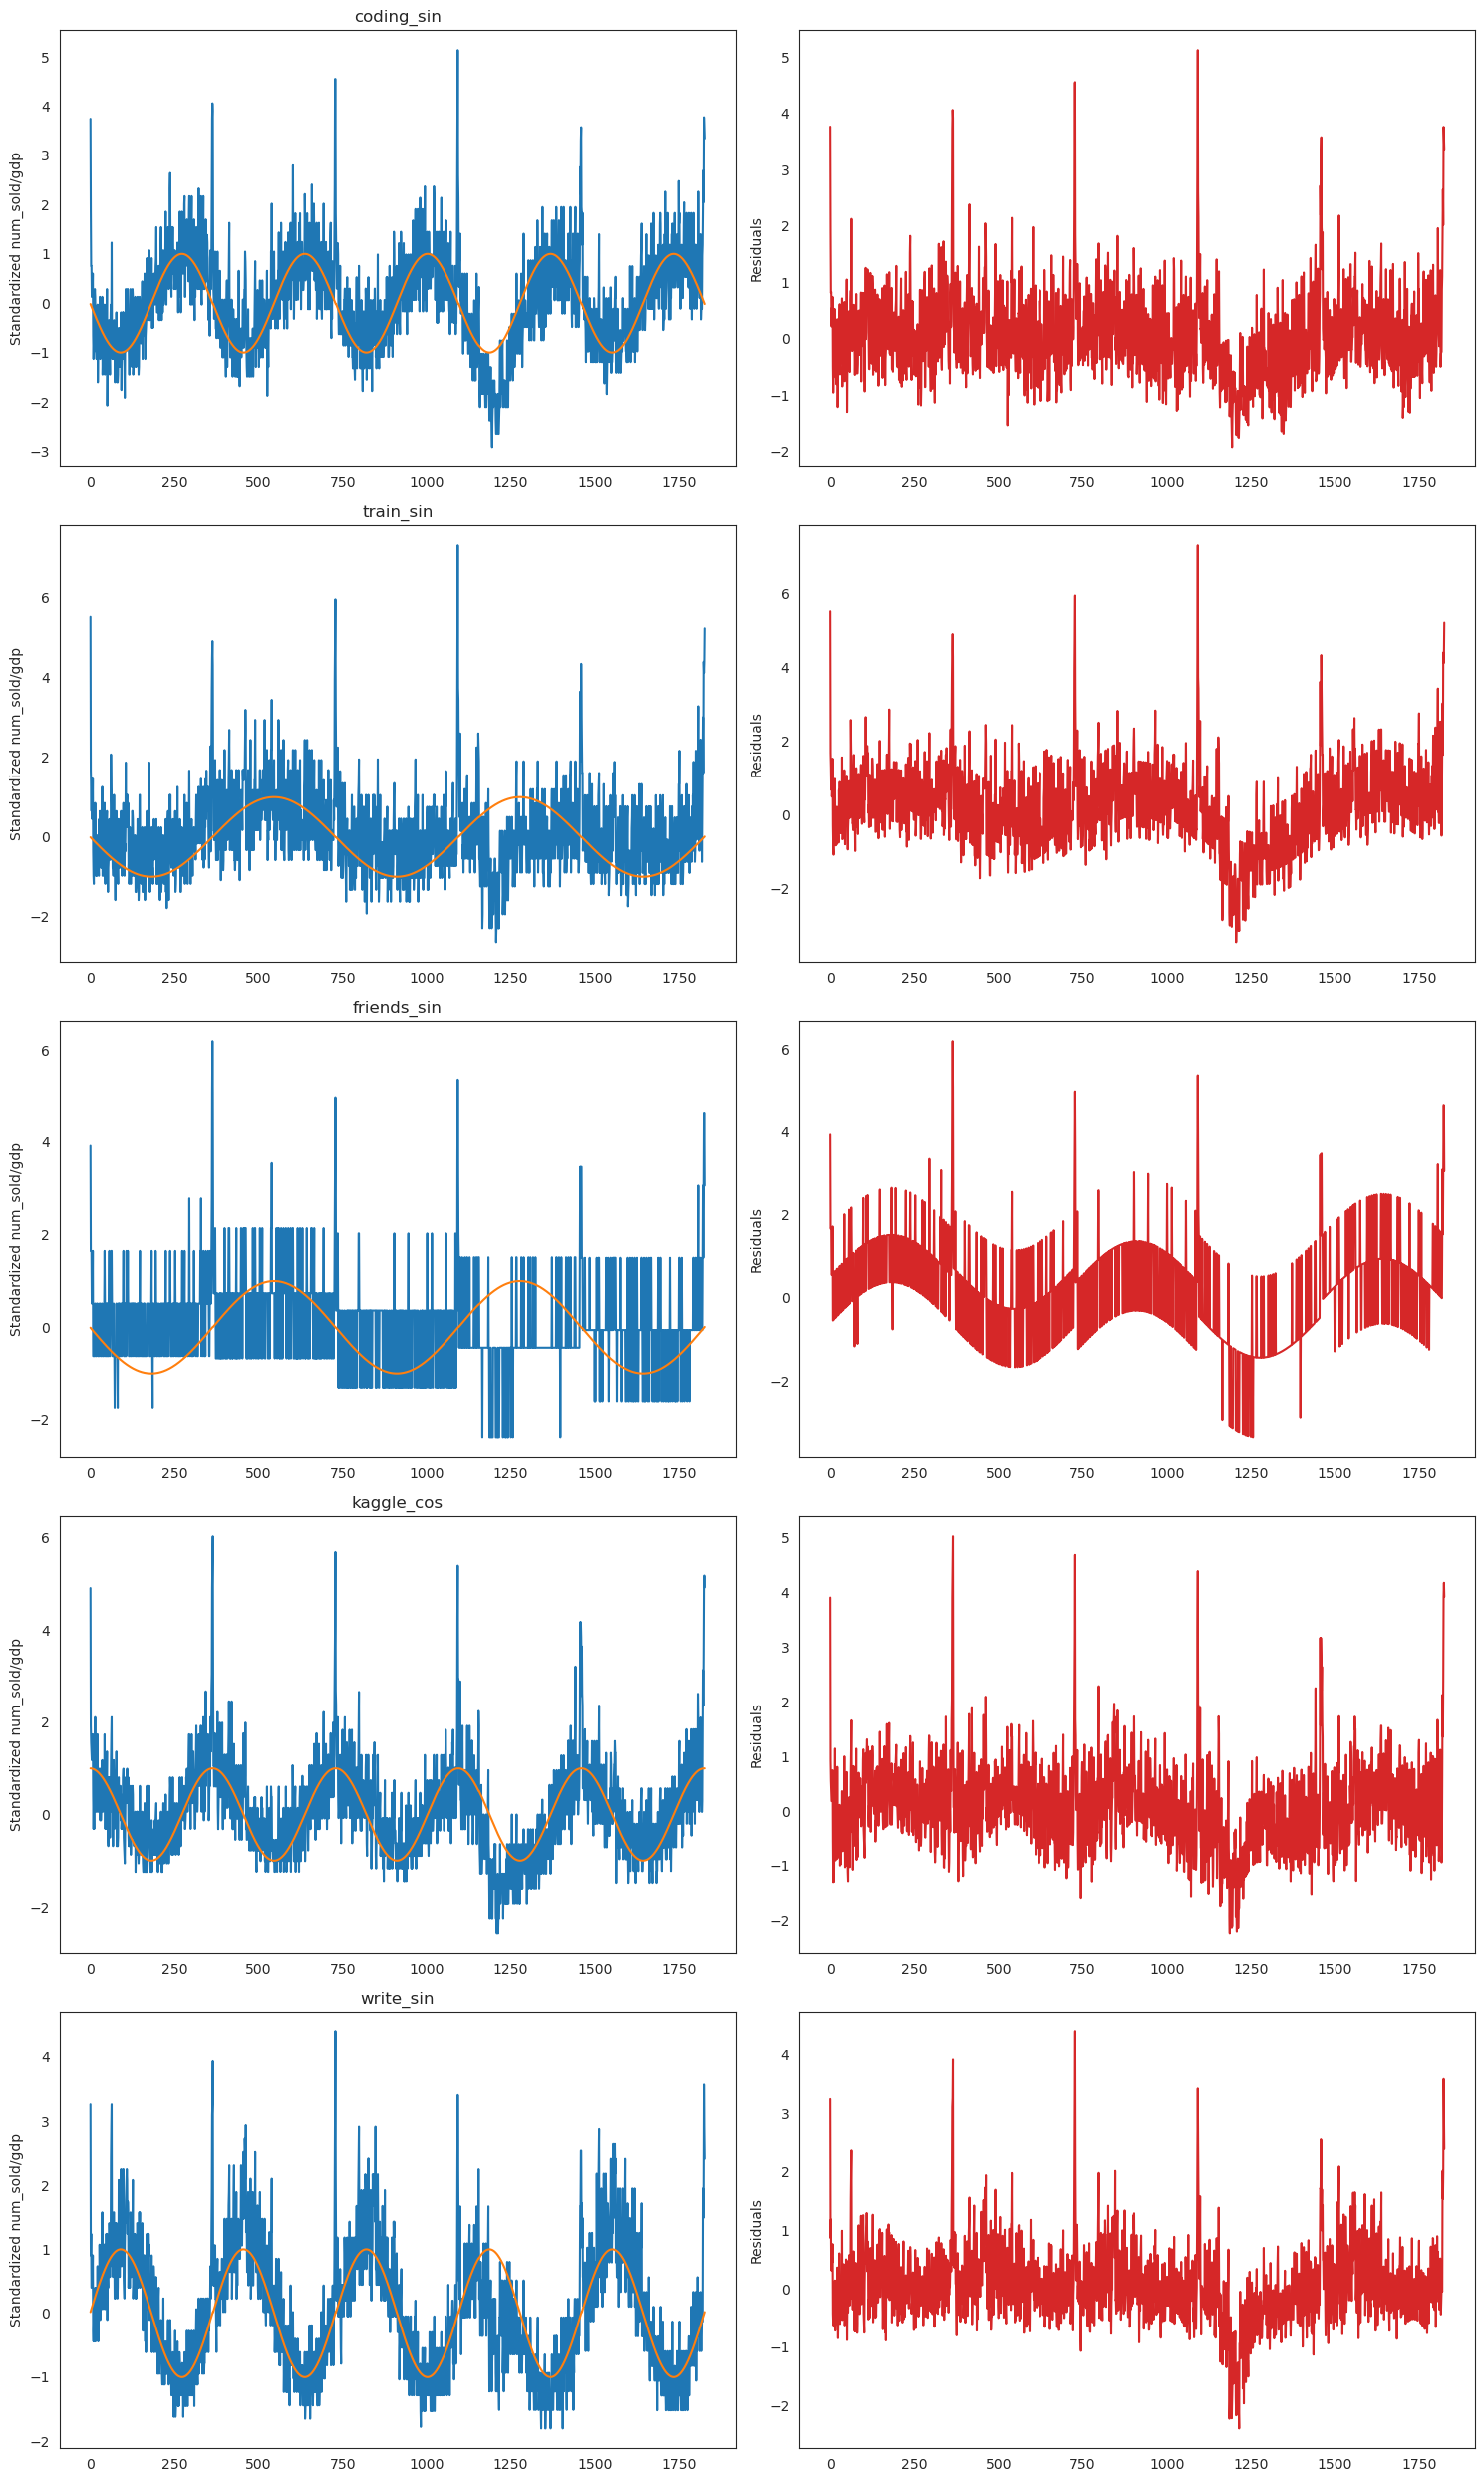

In [12]:
sines = ['coding_sin',  'train_sin', 'friends_sin', 'kaggle_cos', 'write_sin']
products = list(train['product'].unique())
fig = plt.figure(figsize=(15,25))
i=1
for idx, (sinusoidal, product) in enumerate(dict(zip(sines, products)).items()):
    temp = pd.concat([train,target],axis=1).loc[(train['country']=='Argentina')&(train['store']=='Kaggle Learn')&(train['product']==product)].copy()
    scaler = StandardScaler()
    fig.add_subplot(5,2,i)
    i+=1
    plt.plot(range(len(temp)),scaler.fit_transform((temp['num_sold']/temp['gdp']).values.reshape(-1,1)))
    plt.plot(range(len(temp)), temp[sinusoidal])
    plt.ylabel("Standardized num_sold/gdp")
    plt.title(sinusoidal)
    num_sold_scaled = scaler.fit_transform((temp['num_sold']/temp['gdp']).values.reshape(-1,1)).squeeze()
    num_sold_mean = np.mean(num_sold_scaled)
    fig.add_subplot(5,2,i)
    i+=1
    plt.plot(range(len(temp)), scaler.fit_transform((temp['num_sold']/temp['gdp']).values.reshape(-1,1)).squeeze() - (temp[sinusoidal].values), c='tab:red')
    plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# 4. Generalized Additive Model (PyGAM)

For the cross-validation, I used 5 fold sliding window. I split each fold test set into a "public LB estimate" and a "private LB estimate" so that there was a 3 month gap between the "private LB estimate" and the fold's training set. Then I chose features based on the "private LB estimate."

In [13]:
def SMAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [14]:
def get_cv_scores(model, residual_plots=False):
    """
    Train data consists of 2 years (to capture seasonality in products)
    Public validation set consists of 3 months after train data
    Private validation set consists of 9 months after public validation data
    
    Fold 1:
        Train 1/2017 to 12/2018
        Public 1/2019 to 3/2019
        Private 4/2019 to 12/2019
    Fold 2:
        Train 4/2017 to 3/2019
        Public 4/2019 to 6/2019
        Private 7/2019 to 3/2020
    Fold 3:
        Train 7/2017 to 6/2019
        Public 7/2019 to 9/2019
        Private 10/2019 to 6/2020
    Fold 4:
        Train 10/2017 to 9/2019
        Public 10/2019 to 1/2020
        Private 2/2020 to 10/2020
    Fold 5:
        Train 1/2018 to 12/2019
        Public 1/2020 to 3/2020
        Private 4/2020 to 12/2020
    ...
    """
    scores = []
    public_scores = []
    all_preds = []
    train_months = [[1,12], [4,3], [7,6], [10,9]]
    train_years = [[2017,2018], [2017, 2019], [2017,2019], [2017,2019]]
    public_months = [[1,3], [4,6], [7,9], [10,1]]
    public_years = [[2019, 2019], [2019, 2019], [2019,2019], [2019, 2020], [2020, 2020]]
    valid_months = [[4,12],[7,3],[10,6], [2,10]]
    valid_years = [[2019, 2019], [2019,2020], [2019,2020], [2020, 2020], [2020, 2020]]

    train_eom_days = [31, 31, 30, 30]
    public_eom_days = [31, 30, 30, 31]
    valid_eom_days = [31, 31, 30, 31]
    i = 0
    while valid_years[0][0] != 2022:
        
        train_index = list(train.loc[(train['date']>=pd.to_datetime(f'{train_months[i][0]}/{train_years[i][0]}'))&(train['date']<=pd.to_datetime(f'{train_months[i][1]}/{train_eom_days[i]}/{train_years[i][1]}'))].index)
        valid_index = list(train.loc[(train['date']>=pd.to_datetime(f'{valid_months[i][0]}/{valid_years[i][0]}'))&(train['date']<=pd.to_datetime(f'{valid_months[i][1]}/{valid_eom_days[i]}/{valid_years[i][1]}'))].index)
        public_index = list(train.loc[(train['date']>=pd.to_datetime(f'{public_months[i][0]}/{public_years[i][0]}'))&(train['date']<=pd.to_datetime(f'{public_months[i][1]}/{public_eom_days[i]}/{public_years[i][1]}'))].index)
        train_years[i][0], train_years[i][1] = train_years[i][0]+1, train_years[i][1]+1
        valid_years[i][0], valid_years[i][1] = valid_years[i][0]+1, valid_years[i][1]+1
        public_years[i][0], public_years[i][1] = public_years[i][0]+1, public_years[i][1]+1
        i+=1
        if i==4: i = 0
    
        X_train, X_valid, X_public = X.iloc[train_index, 1:], X.iloc[valid_index, 1:], X.iloc[public_index, 1:]
        y_train, y_valid, y_public = y.iloc[train_index], y.iloc[valid_index], y.iloc[public_index]
        
    
        model.fit(X_train, y_train)
        
        fold_preds1 = model.predict(X_public)
        fold_preds1 = np.round(fold_preds1, 0)
        fold_smape = SMAPE(y_public, fold_preds1)
        public_scores.append(fold_smape)
        
        fold_preds2 = model.predict(X_valid)
        fold_preds2 = np.round(fold_preds2, 0)
        fold_smape = SMAPE(y_valid, fold_preds2)
        scores.append(fold_smape)
        
    print("Private LB Estimate")
    mean_smape = np.mean(scores)
    rounded_mean = np.round(mean_smape,2)
    std_smape = np.std(scores)
    rounded_std = np.round(std_smape,2)
    print(f"Mean SMAPE {rounded_mean} (sd: {rounded_std})")
    median_smape = np.median(scores)
    rounded_median = np.round(median_smape,2)
    print(f"Median SMAPE {rounded_median}")
    print(f"scores={np.round(scores,2)}\n")
    
    print("Public LB Estimate")
    mean_smape = np.mean(public_scores)
    rounded_mean = np.round(mean_smape,2)
    std_smape = np.std(public_scores)
    rounded_std = np.round(std_smape,2)
    print(f"Mean SMAPE {rounded_mean} (sd: {rounded_std})")
    median_smape = np.median(public_scores)
    rounded_median = np.round(median_smape,2)
    print(f"Median SMAPE {rounded_median}")
    print(f"scores={np.round(public_scores,2)}")
    
    if residual_plots:
        target = y.copy()
        target = pd.concat([target, pd.Series(fold_preds2, index=y_valid.index, name='preds')],axis=1)
        target.loc[y_public.index, 'preds'] = fold_preds1
        countries = ['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']
        stores = ['Kagglazon', 'Kaggle Learn', 'Kaggle Store']
        products = ['Using LLMs to Improve Your Coding', 'Using LLMs to Train More LLMs','Using LLMs to Win Friends and Influence People',
                    'Using LLMs to Win More Kaggle Competitions', 'Using LLMs to Write Better']
        for _ in range(8):
            country = random.choice(countries)
            store = random.choice(stores)
            products = random.choice(products)

            temp = target.loc[(train[country]==1)&(train[store]==1)&(train[product]==1)].copy()
            fig = plt.figure(figsize=(15,5))
            plt.scatter(x=list(temp.index), y=temp['num_sold'], alpha=.5, s=5)
            plt.scatter(x=list(temp.index), y=temp['preds'], c='tab:red', alpha=.5, s=5)
            plt.title(f"{country} / {store} / {product}\nSMAPE: {SMAPE(temp.dropna(axis=0)['num_sold'], temp.dropna(axis=0)['preds'])}")
            plt.ylabel('num_sold')
            plt.show()

            fig, ax = plt.subplots(figsize=(15, 5))
            xaxis = list(temp.index)
            residuals = temp['preds']-temp['num_sold']
            ax.scatter(x=xaxis, y=residuals, s=5, c='tab:red')
            for i in range(10):
                extreme_idx = np.abs(residuals).argmax()
                xcoord = residuals.index[extreme_idx]
                ycoord = residuals[xcoord]
                pointdate = train.iloc[xcoord]['date']
                ax.annotate(f'{pointdate.day_name()}, {pointdate.month}-{pointdate.day}', xy=(xcoord, ycoord), xycoords='data', fontsize=5)
                residuals = residuals.drop(xcoord)
            plt.ylabel('pred - num_sold')
            plt.show()

In [15]:
train = pd.concat([train, target], axis=1)

In [16]:
countries = ['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']
stores = ['Kagglazon', 'Kaggle Learn', 'Kaggle Store']
products = ['Using LLMs to Improve Your Coding', 'Using LLMs to Train More LLMs','Using LLMs to Win Friends and Influence People',
            'Using LLMs to Win More Kaggle Competitions', 'Using LLMs to Write Better']

X = train.copy()
X = X.drop(['country', 'store', 'product']+countries+stores+products, axis=1).reset_index(drop=True).fillna(0)
X['log_gdp'] = np.log(X['gdp'])
y = X.pop('num_sold')

Private LB Estimate
Mean SMAPE 13.9 (sd: 8.5)
Median SMAPE 12.73
scores=[ 5.2   6.06 13.22 15.55 12.73 10.19 26.99 29.76  5.44]

Public LB Estimate
Mean SMAPE 7.94 (sd: 4.33)
Median SMAPE 5.58
scores=[ 4.99  5.22  5.03  5.58  8.28 17.75  6.07 13.44  5.07]


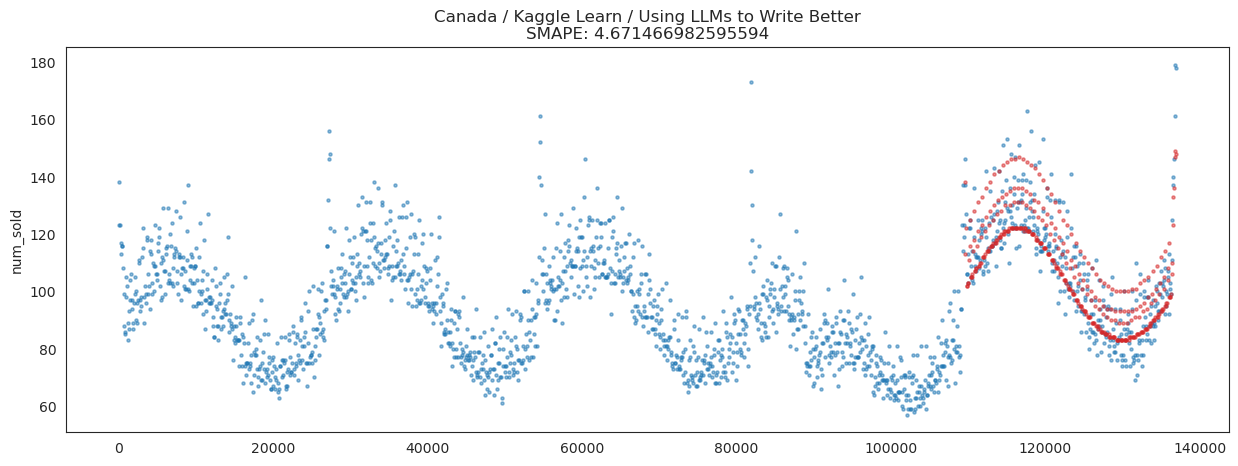

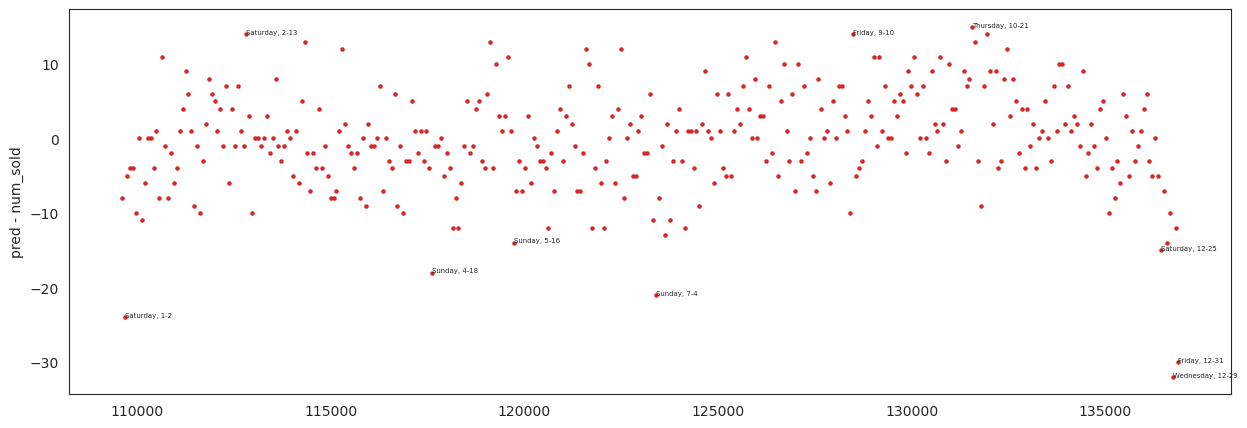

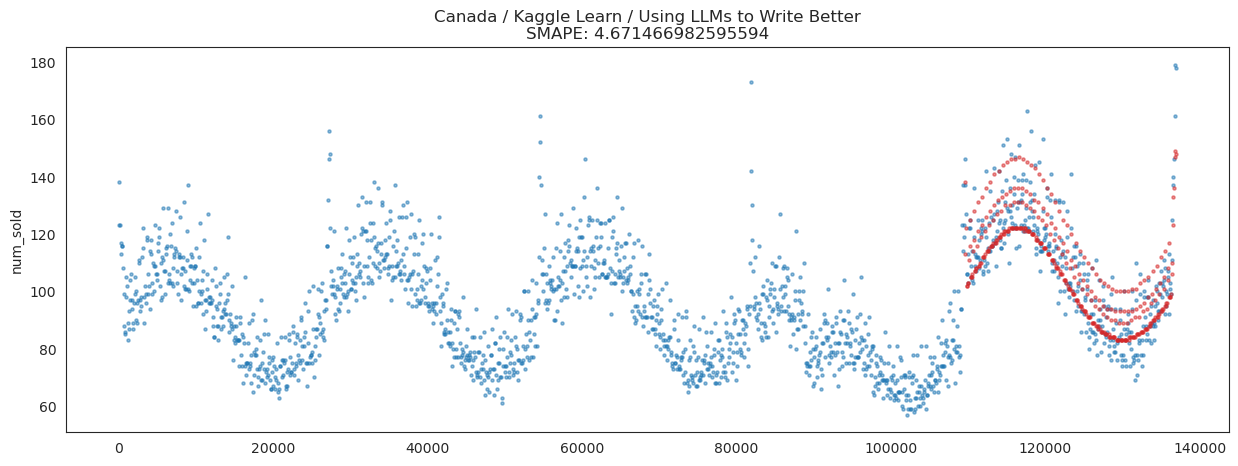

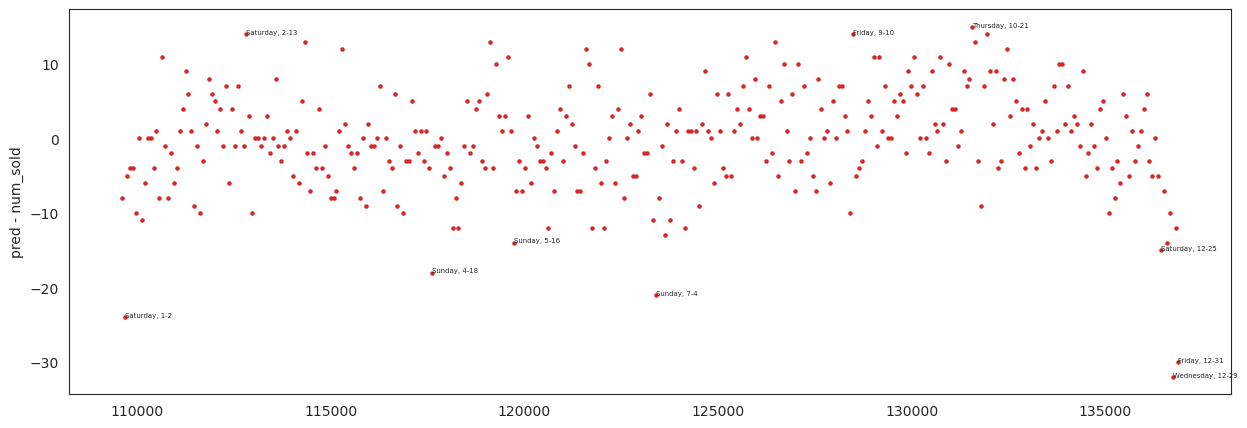

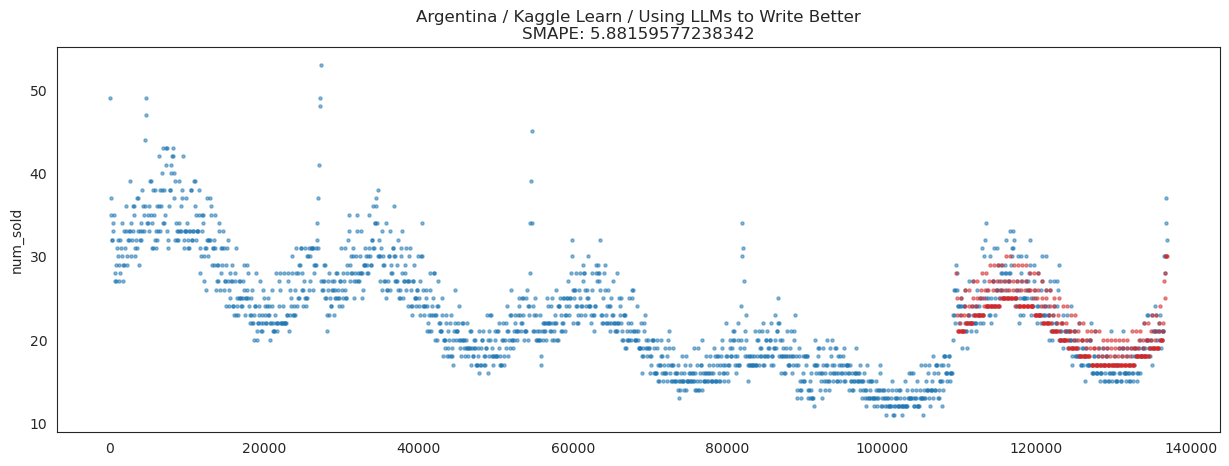

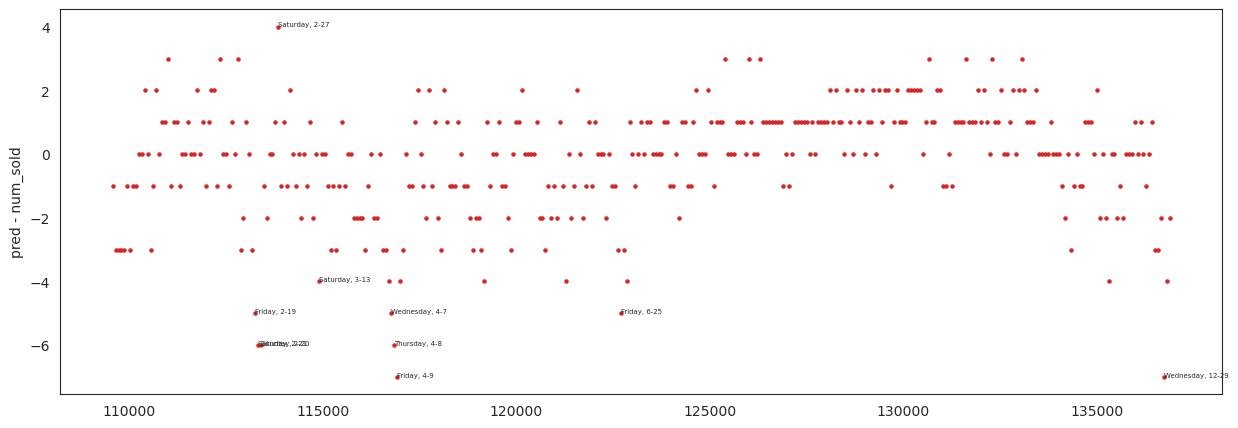

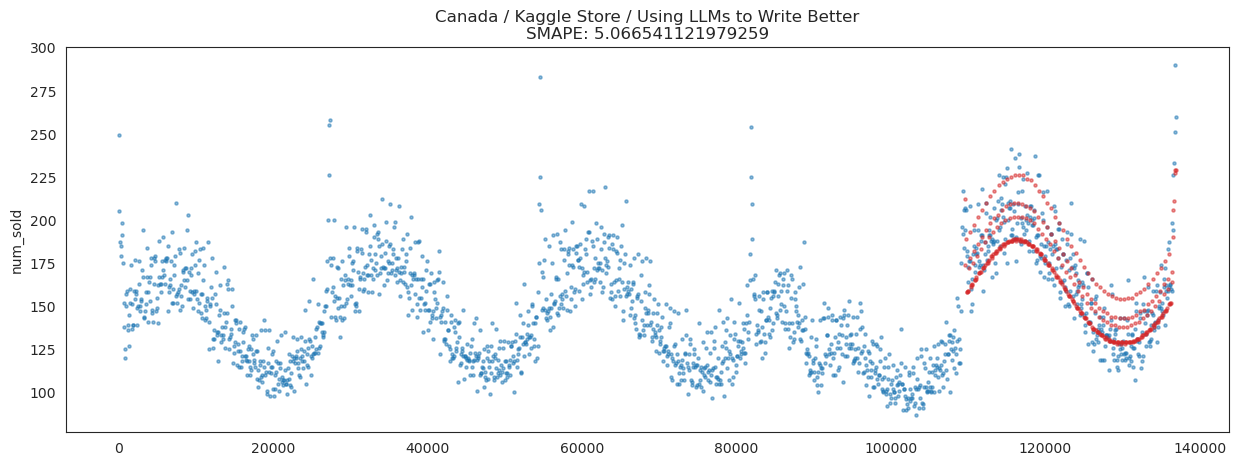

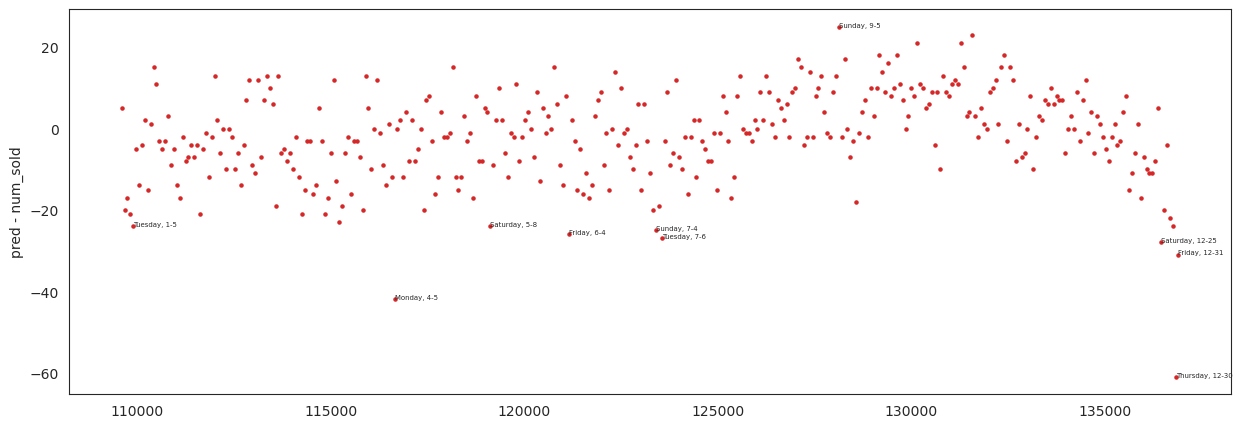

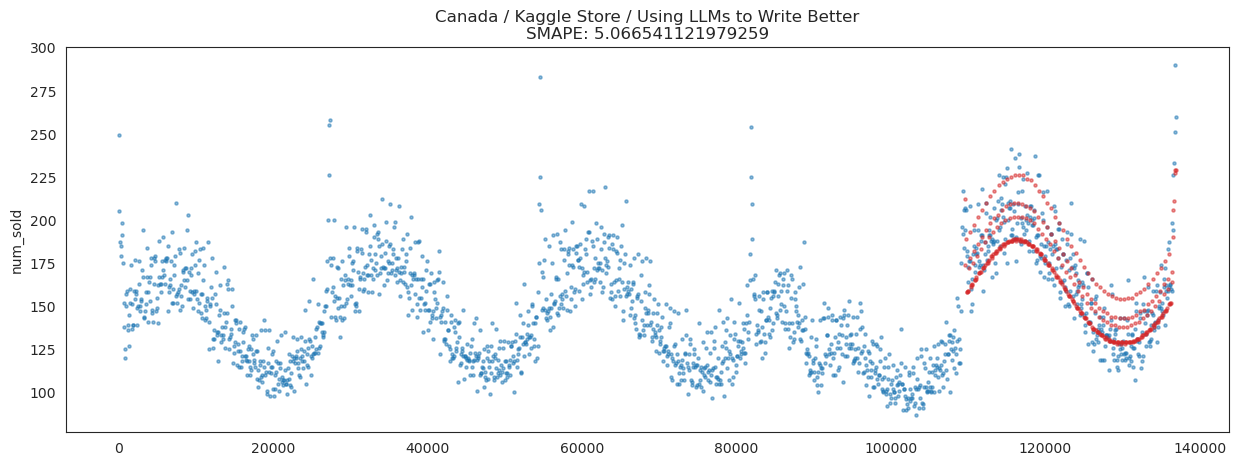

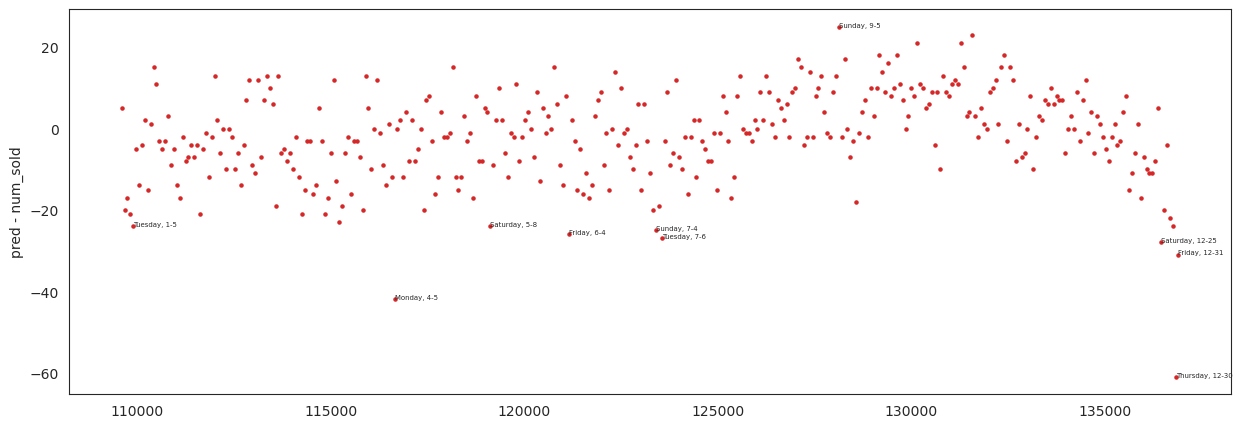

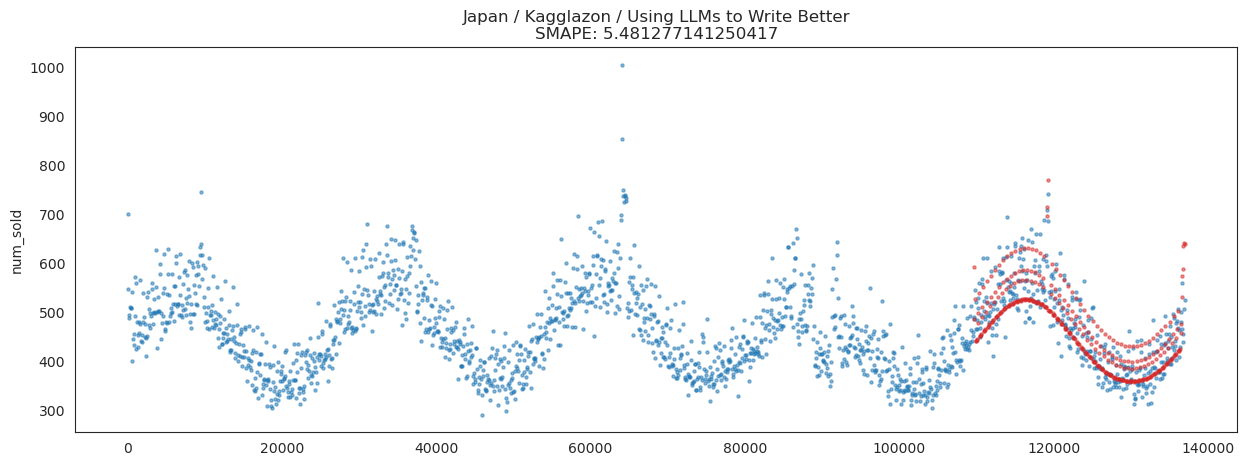

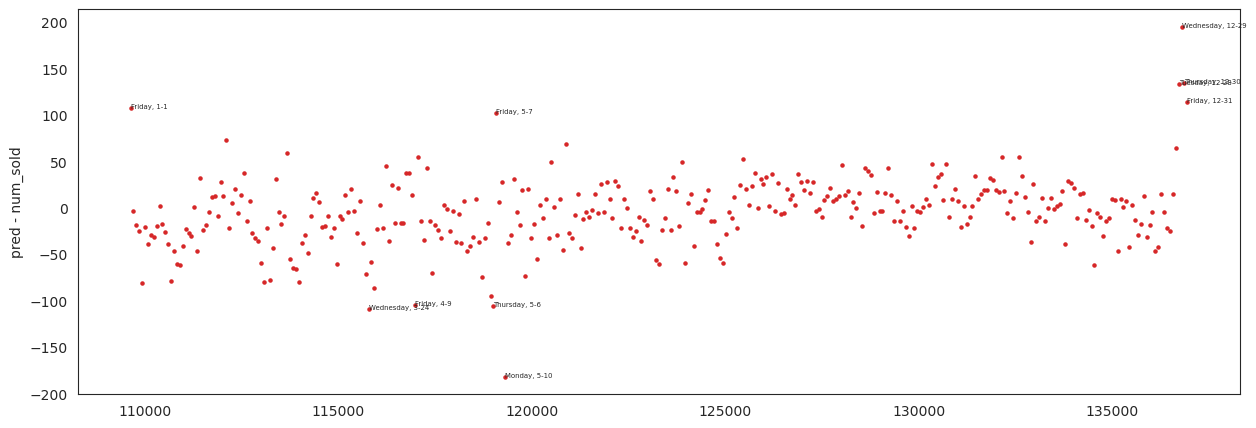

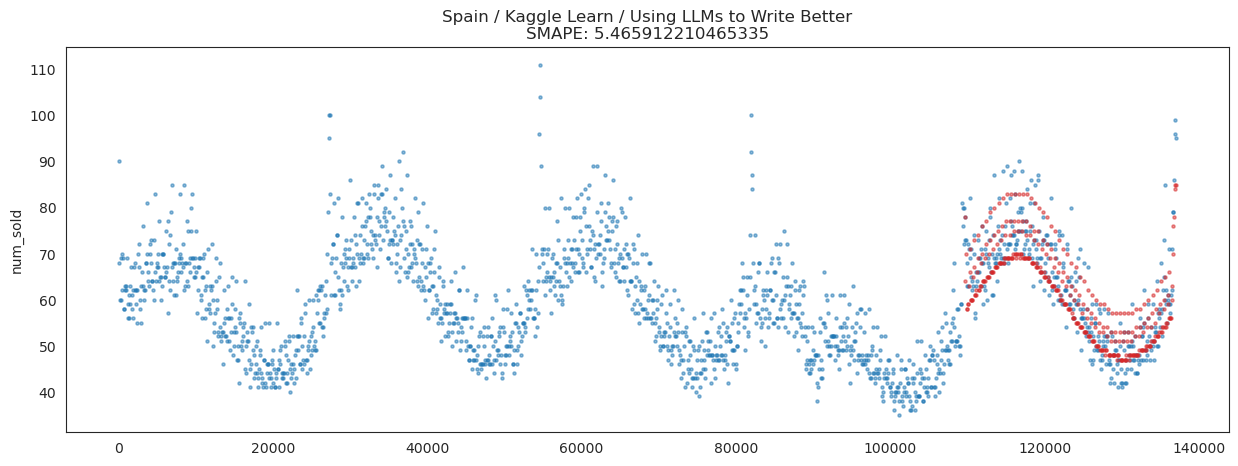

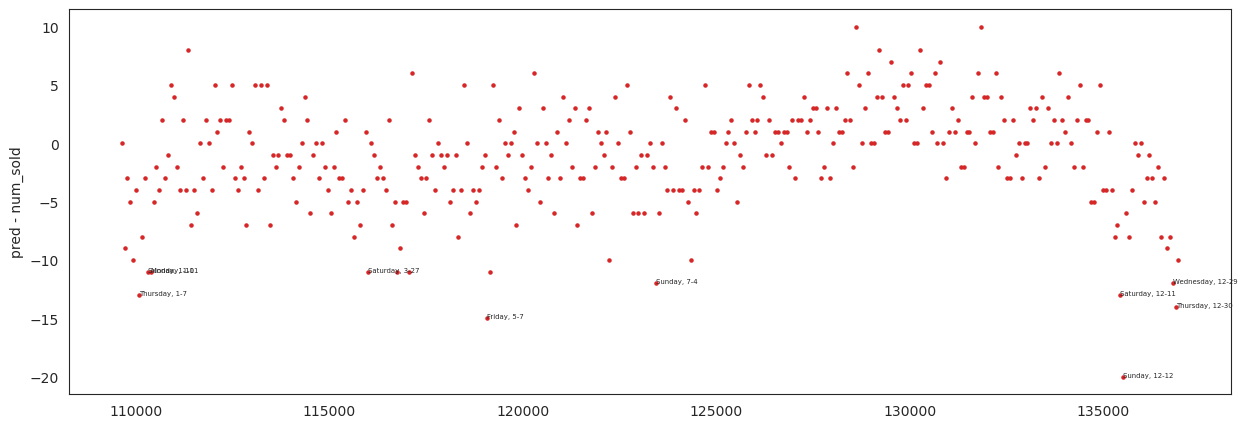

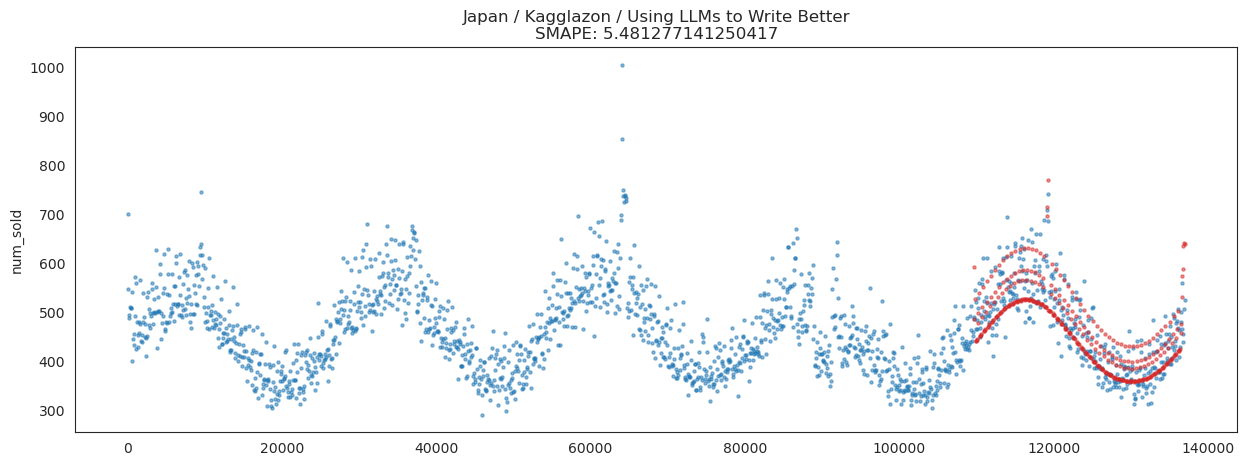

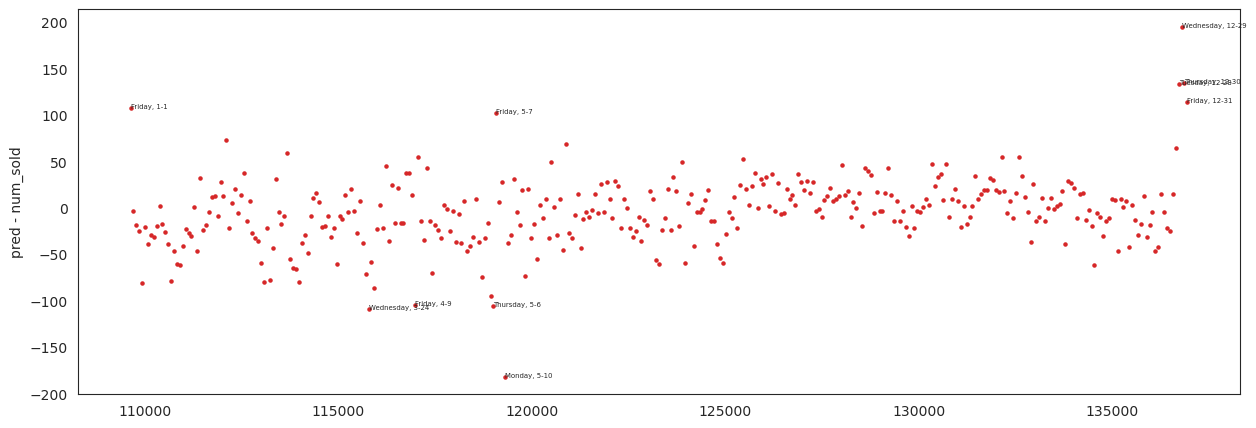

In [17]:
gam = PoissonGAM(
    # store and product categorical variables
    f(1) # store_enc
    + f(2) # product_enc

    # date features
    + f(5) # weekday
    + f(11) # even_year

    # seasonal effects based on dayofyear and product
    + l(15) # coding_sin
    + l(16) # train_sin
    + l(17) # friends_sin
    + l(18) # kaggle_cos
    + l(19) # write_sin

    # dates found through inspection which had larger than average num_sold each year
    + f(21) # Jan1
    + f(22) # Dec26
    + f(23) # Dec27
    + f(24) # Dec28
    + f(25) # Dec29
    + f(26) # Dec30
    + f(27) # Dec31
    + f(30) # JapanMay7
    + f(31) # JapanMay8
    + f(32) # JapanMay9

    # log(gdp per capita)
    + s(35, n_splines=60) # log_gdp
)
get_cv_scores(gam,residual_plots=True)

# 5. Final predictions

In [18]:
test['log_gdp'] = np.log(test['gdp'])
X_test = test[X.columns].copy()
gam.fit(X.iloc[:, 1:], y)
y_pred = gam.predict(X_test.iloc[:,1:])

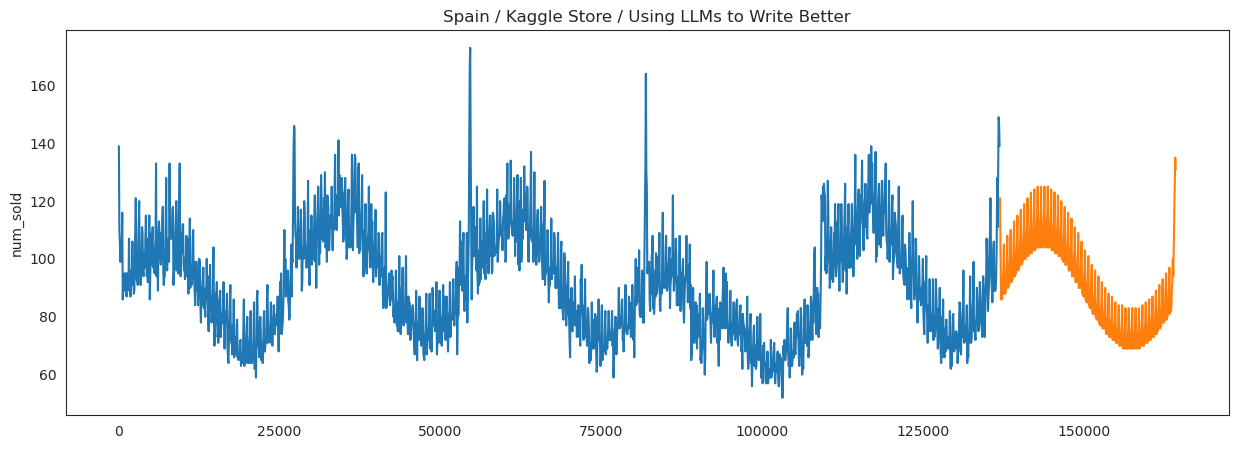

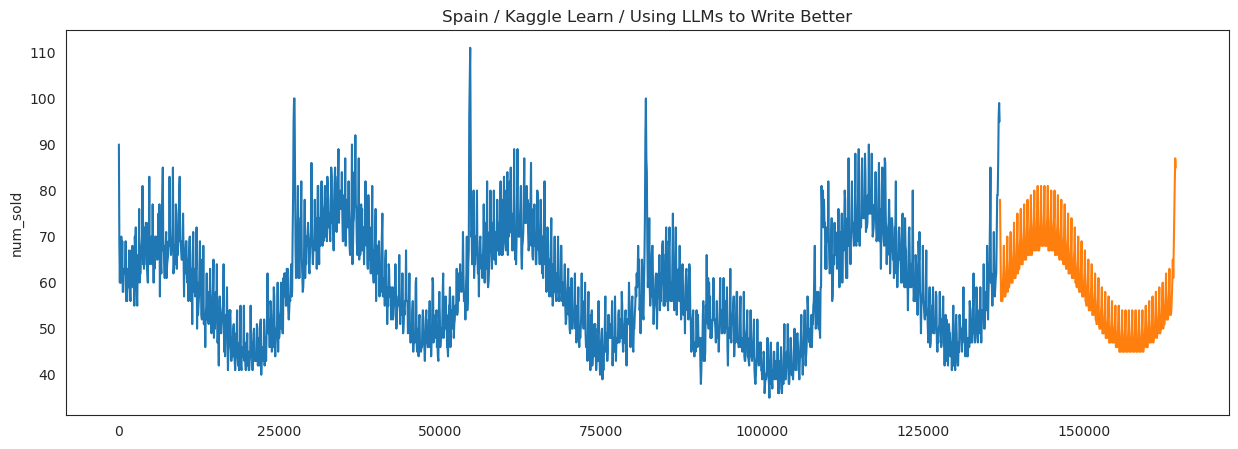

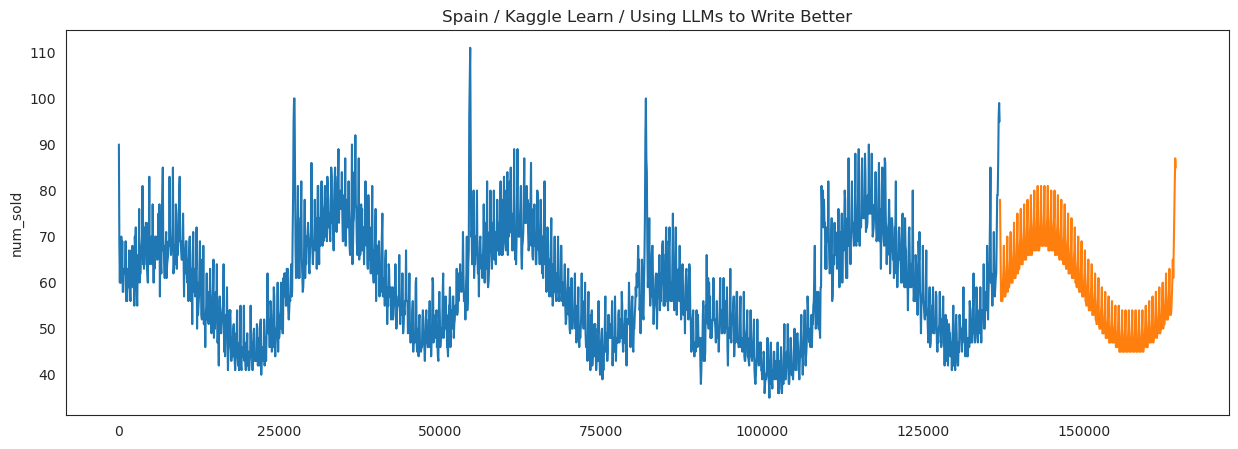

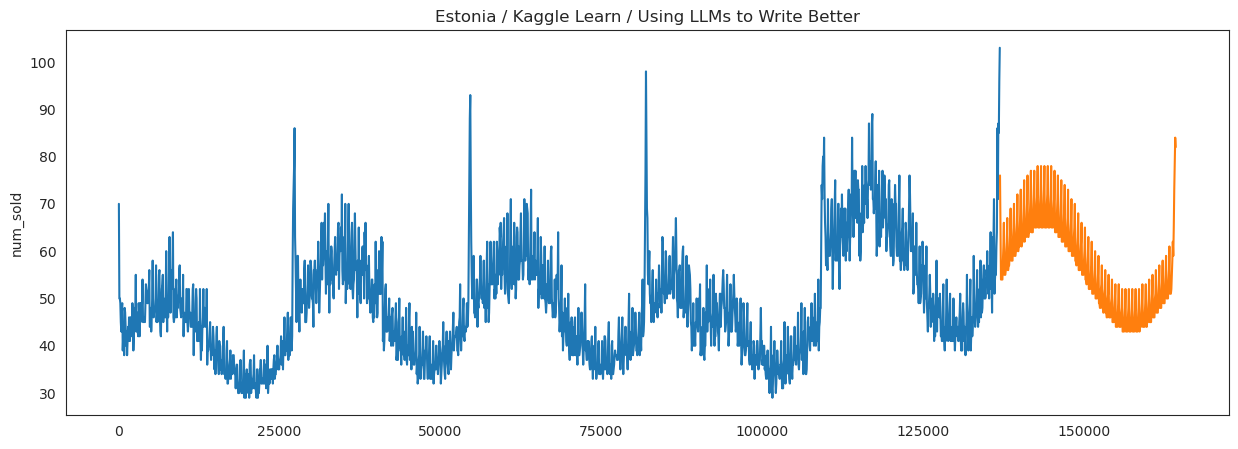

In [21]:
countries = ['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']
stores = ['Kagglazon', 'Kaggle Learn', 'Kaggle Store']
products = ['Using LLMs to Improve Your Coding', 'Using LLMs to Train More LLMs','Using LLMs to Win Friends and Influence People',
            'Using LLMs to Win More Kaggle Competitions', 'Using LLMs to Write Better']

df_train = pd.concat([X, y],axis=1)
df_test = pd.concat([X_test, pd.Series(y_pred,name='num_sold')],axis=1)
for _ in range(4):
    country = random.choice(countries)
    store = random.choice(stores)
    products = random.choice(products)

    temp_train = df_train.loc[(train['country']==country)&(train['store']==store)&(train['product']==product)].copy()
    temp_test = df_test.loc[(test['country']==country)&(test['store']==store)&(test['product']==product)].copy()
    fig = plt.figure(figsize=(15,5))
    train_x = list(temp_train.index)
    test_x = list(temp_test.index +max(train_x))
    plt.plot(train_x, temp_train['num_sold'])
    plt.plot(test_x, temp_test['num_sold'], c='tab:orange')
    plt.ylabel('num_sold')
    plt.title(f"{country} / {store} / {product}")
    plt.show()

In [20]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e19/sample_submission.csv")
submission['num_sold'] = y_pred
y_pred = np.round(y_pred,0)

submission['num_sold'] = y_pred
submission.to_csv('submission.csv', index=False)
submission.head()

,id,num_sold
0,136950,49.0
1,136951,49.0
2,136952,8.0
3,136953,47.0
4,136954,37.0
